In [3]:
## Librerias
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from EEGNet_model import *
from EEGNet_train import *



In [10]:
def get_dataset_v3(dir_task,num_class):
    """
    Construye el dataset a partir de la direccion de carpetas y la cantidad de clases
    a clasificar. La v3 get_dataset obtiene el train_set, val_set y test_set de forma separada
    para el test de independencia de clases
    
    Argumentos: dir_task(Direccion de carpetas) y num_class(cantidad de clases)
    Output: inputs(imagenes) y targets(vector de clases) 
   
    """
    
    train_dir = os.path.join(dir_task, "train_data")
    val_dir = os.path.join(dir_task, "val_data")
    test_dir = os.path.join(dir_task, "test_data")
    
    # Sizes
    TRAIN_SIZE = 30
    VAL_SIZE = 30
    BATCH_SIZE = 100

    # Training
    X_train1 = np.zeros(shape=(TRAIN_SIZE,128, 128, 3))
    X_train2 = np.zeros(shape=(TRAIN_SIZE,128, 128, 3))
    
    fnames_tasks = [os.path.join(train_dir,fname) for fname in os.listdir(train_dir)]
    
    fnames = [os.path.join(fnames_tasks[0],fname) for fname in os.listdir(fnames_tasks[0])]
    for i in range(0,TRAIN_SIZE):
        img_path = fnames[i]
        img = image.load_img(img_path,target_size=(128,128))
        x = image.img_to_array(img)
        x = x.astype('float32') / 255
        X_train1[i] = x
    
    fnames = [os.path.join(fnames_tasks[1],fname) for fname in os.listdir(fnames_tasks[1])]
    for i in range(0,TRAIN_SIZE):
        img_path = fnames[i]
        img = image.load_img(img_path,target_size=(128,128))
        x = image.img_to_array(img)
        x = x.astype('float32') / 255
        X_train2[i] = x
    
    X_train = np.concatenate((X_train1,X_train2),axis = 0)
    
    Y_train1 = np.zeros((TRAIN_SIZE,), dtype=np.float64)
    Y_train2 = np.ones((TRAIN_SIZE,), dtype=np.float64)
    Y_train = np.concatenate((Y_train1,Y_train2))

    # Validation 
    
    X_val1 = np.zeros(shape=(VAL_SIZE,128, 128, 3))
    X_val2 = np.zeros(shape=(VAL_SIZE,128, 128, 3))
    
    fnames_tasks = [os.path.join(val_dir,fname) for fname in os.listdir(train_dir)]
    
    fnames = [os.path.join(fnames_tasks[0],fname) for fname in os.listdir(fnames_tasks[0])]
    for i in range(0,VAL_SIZE):
        img_path = fnames[i]
        img = image.load_img(img_path,target_size=(128,128))
        x = image.img_to_array(img)
        x = x.astype('float32') / 255
        X_val1[i] = x
    
    fnames = [os.path.join(fnames_tasks[1],fname) for fname in os.listdir(fnames_tasks[1])]
    for i in range(0,VAL_SIZE):
        img_path = fnames[i]
        img = image.load_img(img_path,target_size=(128,128))
        x = image.img_to_array(img)
        x = x.astype('float32') / 255
        X_val2[i] = x

    X_val = np.concatenate((X_val1,X_val2),axis = 0)
    
    Y_val1 = np.zeros((VAL_SIZE,), dtype=np.float64)
    Y_val2 = np.ones((VAL_SIZE,), dtype=np.float64)
    Y_val = np.concatenate((Y_val1,Y_val2))

    #Testing 
    
    type_class = 'binary'
    if (num_class != 2):
        type_class = 'sparse'
    
    datagen_task = ImageDataGenerator(rescale=1./255)
    
    test_task = datagen_task.flow_from_directory(
        test_dir, 
        batch_size = BATCH_SIZE,
        target_size=(128, 128),
        class_mode = type_class
        )
    
    num_samples = 0
    for i in range(len(test_task)):
        num_samples += len(test_task[i][1]) 
    
    X_test = np.zeros(shape=(num_samples, 128, 128, 3))
    Y_test = np.zeros(shape=(num_samples))
    i=0

    for inputs_batch,labels_batch in test_task:
        X_test[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] =  inputs_batch
        Y_test[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= num_samples:
            break
            
    return X_train,X_val,X_test,Y_train,Y_val,Y_test

In [11]:
def Kcross_validation_v3(num_class,X_train,X_val,X_test,Y_train,Y_val,Y_test,repetitions):
    """
   
        
    """
    
    # Per-fold score containers 
    acc_per_fold = []
    val_per_fold = []
    lpo = LeavePOut(p=2)
    
    fold_n = 1
    list_channels = np.array([0,1,2,3,4])
    step_per_chn_train = 6
    step_per_chn_val = 6
    
    for train,val in lpo.split(list_channels):
        
        train_index = np.zeros(shape = 0)
        val_index = np.zeros(shape = 0)

        for i in train:
            temp = range(i*step_per_chn_train,(i+1)*step_per_chn_train)
            train_index = np.concatenate((train_index,temp))

        for k in val:
            temp = range(k*step_per_chn_val,(k+1)*step_per_chn_val)
            val_index = np.concatenate((val_index,temp))
        
        train_index = np.concatenate((train_index,train_index+30))
        val_index = np.concatenate((val_index,val_index+30))
        
        train_index = train_index.astype(int)
        val_index = val_index.astype(int)
        
        np.random.shuffle(train_index)
        np.random.shuffle(val_index)
        
        EEGNet = get_EEGNet(num_class)
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_n} and Validating with Chn {val[0]+1}')
        print(f'Entrenando con canales {train} y validando con canales {val}')

        pat = 50
        early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=pat, verbose=1)
        model_checkpoint = ModelCheckpoint('./model_checkpoint', verbose=1, save_best_only=True, monitor='val_acc',
        mode='max')
        
        history = EEGNet.fit(X_train[train_index],Y_train[train_index],
                             epochs = 50, steps_per_epoch = 2, validation_data = (X_val[val_index],Y_val[val_index]), 
                             callbacks=[early_stopping, model_checkpoint]
                            )
        plot_metrics(history,fold_n)
    
        EGGNetnew = tf.keras.models.load_model('./model_checkpoint')
        val_scores = EGGNetnew.evaluate(X_val[val_index],Y_val[val_index],verbose=2)
        test_scores = EGGNetnew.evaluate(X_test,Y_test,verbose=2)
    
        print(f'Val-Score for fold {fold_n}: {EEGNet.metrics_names[0]} of {val_scores[0]}; {EEGNet.metrics_names[1]} of {val_scores[1]*100}%')
        print(f'Test-Score for fold {fold_n}: {EEGNet.metrics_names[0]} of {test_scores[0]}; {EEGNet.metrics_names[1]} of {test_scores[1]*100}%')
        acc_per_fold.append((val_scores[1],test_scores[1]))
        val_per_fold.append(val_scores[1])
        
         # Increse number of fold
        fold_n = fold_n + 1
        
    val_mean,val_std,test_mean,test_std = print_subject_results(val_per_fold,acc_per_fold,repetitions)
    
    return val_mean,val_std,test_mean,test_std

Found 10 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 1
Entrenando con canales [2 3 4] y validando con canales [0 1]
Epoch 1/50
2/2 [==============================] - 2s 602ms/step - loss: 0.7215 - acc: 0.5556 - val_loss: 0.7676 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 524ms/step - loss: 0.6545 - acc: 0.6944 - val_loss: 0.7676 - val_acc: 0.6250

Epoch 00002: val_acc improved from 0.50000 to 0.62500, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 500ms/step - loss: 0.4986 - acc: 0.9722 - val_loss: 0.7626 - val_acc: 0.5833

Epoch 00003: val_acc did not improve from 0.62500
Epoch 4/50
2/2 [======================

2/2 [==============================] - 1s 452ms/step - loss: 0.0667 - acc: 1.0000 - val_loss: 0.6904 - val_acc: 0.5833

Epoch 00042: val_acc did not improve from 0.79167
Epoch 43/50
2/2 [==============================] - 1s 421ms/step - loss: 0.0657 - acc: 1.0000 - val_loss: 0.6883 - val_acc: 0.5833

Epoch 00043: val_acc did not improve from 0.79167
Epoch 44/50
2/2 [==============================] - 1s 462ms/step - loss: 0.0650 - acc: 1.0000 - val_loss: 0.6889 - val_acc: 0.5833

Epoch 00044: val_acc did not improve from 0.79167
Epoch 45/50
2/2 [==============================] - 1s 431ms/step - loss: 0.0602 - acc: 1.0000 - val_loss: 0.6921 - val_acc: 0.5833

Epoch 00045: val_acc did not improve from 0.79167
Epoch 46/50
2/2 [==============================] - 1s 461ms/step - loss: 0.0612 - acc: 1.0000 - val_loss: 0.6962 - val_acc: 0.5417

Epoch 00046: val_acc did not improve from 0.79167
Epoch 47/50
2/2 [==============================] - 1s 455ms/step - loss: 0.0598 - acc: 1.0000 - val_lo

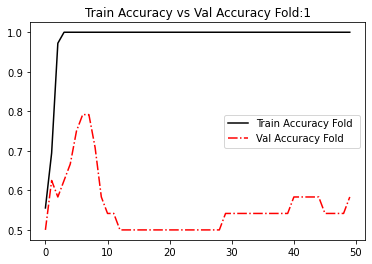

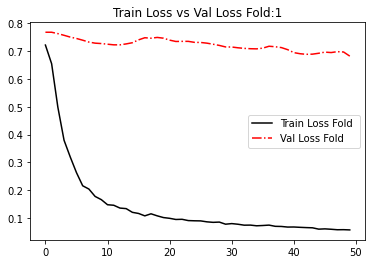

1/1 - 0s - loss: 0.7390 - acc: 0.7917
1/1 - 0s - loss: 0.7574 - acc: 0.6000
Val-Score for fold 1: loss of 0.7390499114990234; acc of 79.16666865348816%
Test-Score for fold 1: loss of 0.7574256658554077; acc of 60.00000238418579%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 1
Entrenando con canales [1 3 4] y validando con canales [0 2]
Epoch 1/50
2/2 [==============================] - 1s 544ms/step - loss: 0.8340 - acc: 0.4722 - val_loss: 0.7747 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 431ms/step - loss: 0.6412 - acc: 0.8333 - val_loss: 0.7788 - val_acc: 0.5000

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/50
2/2 [==============================] - 1s 481ms/step - loss: 0.5093 - acc: 0.9722 - val_loss: 0.7770 - val_acc: 0.5000



2/2 [==============================] - 1s 415ms/step - loss: 0.0668 - acc: 1.0000 - val_loss: 0.6499 - val_acc: 0.7083

Epoch 00041: val_acc did not improve from 0.75000
Epoch 42/50
2/2 [==============================] - 1s 467ms/step - loss: 0.0647 - acc: 1.0000 - val_loss: 0.6495 - val_acc: 0.6667

Epoch 00042: val_acc did not improve from 0.75000
Epoch 43/50
2/2 [==============================] - 1s 439ms/step - loss: 0.0625 - acc: 1.0000 - val_loss: 0.6490 - val_acc: 0.7083

Epoch 00043: val_acc did not improve from 0.75000
Epoch 44/50
2/2 [==============================] - 1s 430ms/step - loss: 0.0621 - acc: 1.0000 - val_loss: 0.6480 - val_acc: 0.7083

Epoch 00044: val_acc did not improve from 0.75000
Epoch 45/50
2/2 [==============================] - 1s 451ms/step - loss: 0.0639 - acc: 1.0000 - val_loss: 0.6462 - val_acc: 0.7083

Epoch 00045: val_acc did not improve from 0.75000
Epoch 46/50
2/2 [==============================] - 1s 441ms/step - loss: 0.0591 - acc: 1.0000 - val_lo

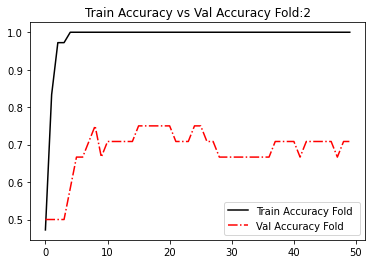

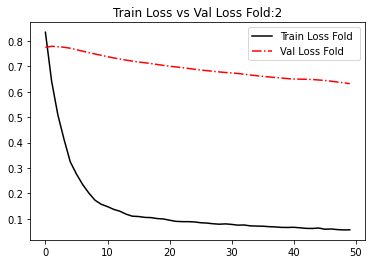

1/1 - 0s - loss: 0.7483 - acc: 0.7500
1/1 - 0s - loss: 0.7614 - acc: 0.5000
Val-Score for fold 2: loss of 0.7483251690864563; acc of 75.0%
Test-Score for fold 2: loss of 0.7613868117332458; acc of 50.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 1
Entrenando con canales [1 2 4] y validando con canales [0 3]
Epoch 1/50
2/2 [==============================] - 1s 520ms/step - loss: 1.0956 - acc: 0.4444 - val_loss: 0.7766 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50


KeyboardInterrupt: 

In [12]:
resultados_finales = []
num_test = 1
num_class = 2
repetitions = 1

dir_task = r'C:\Users\Lenovo\Documents\UTEC\Ciclo 7\ProyectoCNN\Python\Dataset\Test1'
X_train,X_val,X_test,Y_train,Y_val,Y_test = get_dataset_v3(dir_task,num_class)
val_mean,val_std,test_mean,test_std = Kcross_validation_v3(num_class,X_train,X_val,X_test,Y_train,Y_val,Y_test,repetitions)
resultados_finales.append(f'Val: {val_mean} +- {val_std} // Test: {test_mean} +- {test_std}')
    
resultados_finales